In [1]:
#installation dépendances
!pip install -U spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 28.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
!pip install pandas
!pip install matplotlib


In [3]:
pip install langdetect googletrans==4.0.0-rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=910a18b37e9f06f5ebfc1c2fd8a9df09095f599f298e2dbdc096c95eecc288d2
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
  Created wheel fo

In [4]:
#import des dépendances
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from langdetect import detect
import re
import ast
from sklearn.preprocessing import LabelEncoder

In [5]:
#import dataset file with google colab from google drive
from google.colab import drive
drive.mount("/content/drive")



Mounted at /content/drive


In [9]:
#récuperation du dataset en dataframe
df_train = pd.read_csv("/content/drive/MyDrive/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test.csv")
df_test_label = pd.read_csv("/content/drive/MyDrive/test_labels.csv")
df_sample_submission = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")

In [ ]:
#suppression des lignes qui ne sont pas en anglais
def remove_non_english_rows(df, column_name):

    def is_english(text):
        try:
            # Vérifier si le texte est valide
            if not isinstance(text, str) or not text.strip():
                return False  # Considérer les non-textes ou les vides comme non-anglais
            # Détecter la langue
            return detect(text) == 'en'
        except Exception as e:
            # En cas d'erreur, considérer comme non-anglais
            return False

    # Appliquer la fonction par lots pour éviter les surcharges mémoire
    df = df.copy()
    df['is_english'] = df[column_name].map(is_english)  # Ajout d'une colonne temporaire
    df = df[df['is_english']].drop(columns=['is_english'])  # Filtrer et supprimer la colonne temporaire

    return df

print(f"Nombre de lignes train avant suppression: {len(df_train)}")
print(f"Nombre de lignes test avant suppression: {len(df_test)}")


df_train = remove_non_english_rows(df_train, 'comment_text')
df_test = remove_non_english_rows(df_test, 'comment_text')

print(f"Nombre de lignes train après suppression: {len(df_train)}")
print(f"Nombre de lignes test après suppression: {len(df_test)}")


Nombre de lignes train avant suppression: 159571
Nombre de lignes test avant suppression: 153164
Nombre de lignes train après suppression: 155255
Nombre de lignes test après suppression: 142830
Nombre de lignes train avant suppression: 159571
Nombre de lignes test avant suppression: 153164
Nombre de lignes train après suppression: 155247
Nombre de lignes test après suppression: 142803


In [ ]:
#sauvegarde du dataset
df_train.to_csv("/content/drive/MyDrive/train_englishonly.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/test_englishonly.csv", index=False)

In [10]:
df_train = pd.read_csv("/content/drive/MyDrive/train_englishonly.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_englishonly.csv")

In [11]:
print(f"Nombre de lignes train après suppression: {len(df_train)}")
print(f"Nombre de lignes test après suppression: {len(df_test)}")

print(df_train.shape)
print(df_test.shape)

print((df_train['toxic'] == 1).sum())
print((df_train['toxic'] == 0).sum())

Nombre de lignes train après suppression: 155247
Nombre de lignes test après suppression: 142803
(155247, 8)
(142803, 2)
14184
141063


In [12]:
import pandas as pd

# Merge df_test and df_test_label on the 'id' column
df_test = pd.merge(df_test, df_test_label, on='id', how='left')

# Concatenate df_train and the updated df_test
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Now df_combined contains both training and test data with labels for the test set
df_combined.shape

(298050, 8)

In [13]:
#mettre la catégorie toxic comme étant la principale, si une autre colomne est en 1 alors le commentaire est de base considéré comme toxic

# Iterate through the DataFrame rows
for index, row in df_combined.iterrows():
    if row['toxic'] == 0:
        # Check other columns for a value of 1
        for col in ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
            if row[col] == 1:
                # Set 'toxic' to 1 if another column is 1
                df_train.loc[index, 'toxic'] = 1
                break  # Exit inner loop once 'toxic' is updated

In [15]:
print(df_combined.shape)

print((df_combined['toxic'] == 1).sum())
print((df_combined['toxic'] == 0).sum())
print((df_combined['toxic'] == -1).sum())

(298050, 8)
19635
195551
82864


In [16]:

# Remove rows where 'toxic' is -1
df_combined = df_combined[df_combined['toxic'] != -1]

print(df_combined.shape)

print((df_combined['toxic'] == 1).sum())
print((df_combined['toxic'] == 0).sum())
print((df_combined['toxic'] == -1).sum())

(215186, 8)
19635
195551
0


In [17]:
#Equilibrage du dataset toxic/non toxic, on veut au maximum deux fois plus de lignes toxic que non toxic
toxic_count = (df_combined['toxic'] == 1).sum()
non_toxic_count = (df_combined['toxic'] == 0).sum()

print(f"Initial toxic comments: {toxic_count}")
print(f"Initial non-toxic comments: {non_toxic_count}")

# Calculate the target number of non-toxic samples
target_non_toxic_count = min(non_toxic_count, toxic_count * 2)

# If the number of non-toxic samples is already less than or equal to twice the number of toxic samples, do nothing
if non_toxic_count <= target_non_toxic_count:
    print("No balancing needed.")
else:
  # Sample the non-toxic comments
  non_toxic_indices = df_combined[df_combined['toxic'] == 0].index
  sampled_non_toxic_indices = non_toxic_indices[:target_non_toxic_count].tolist()

  # Separate toxic and sampled non-toxic comments
  toxic_df = df_combined[df_combined['toxic'] == 1]
  sampled_non_toxic_df = df_combined.loc[sampled_non_toxic_indices]

  # Combine the toxic and balanced non-toxic comments
  df_balanced = pd.concat([toxic_df, sampled_non_toxic_df], ignore_index=True)

  # Shuffle the balanced dataset
  df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

  print(f"Balanced toxic comments: {(df_balanced['toxic'] == 1).sum()}")
  print(f"Balanced non-toxic comments: {(df_balanced['toxic'] == 0).sum()}")

  # Replace df_combined with the balanced dataset if needed
  df_combined = df_balanced

Initial toxic comments: 19635
Initial non-toxic comments: 195551
Balanced toxic comments: 19635
Balanced non-toxic comments: 39270


In [18]:
#creation a l'aide de df_combined d'un df_train df_validation et df_test avec df_train 70% df_validation 20% et df_test 10%

from sklearn.model_selection import train_test_split

# Assuming df_combined is already created and processed as in your provided code

# Split the data into training, validation, and testing sets
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

# Split into training and temporary sets (test + validation)
df_train, df_temp = train_test_split(df_combined, test_size=1 - train_ratio, random_state=42)

# Split the temporary set into validation and test sets
validation_size = validation_ratio / (validation_ratio + test_ratio)  # Calculate the split ratio
df_validation, df_test = train_test_split(df_temp, test_size=1 - validation_size, random_state=42)

print(f"df_train shape: {df_train.shape}")
print(f"df_validation shape: {df_validation.shape}")
print(f"df_test shape: {df_test.shape}")

df_train shape: (41233, 8)
df_validation shape: (11781, 8)
df_test shape: (5891, 8)


In [19]:
df_train.to_csv("/content/drive/MyDrive/train_balanced.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/test_balanced.csv", index=False)
df_validation.to_csv("/content/drive/MyDrive/validation_balanced.csv", index=False)

In [20]:
df_train = pd.read_csv("/content/drive/MyDrive/train_balanced.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_balanced.csv")
df_validation = pd.read_csv("/content/drive/MyDrive/validation_balanced.csv")

In [21]:
#preprocess

#spacy preprocessing
nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])

def preprocess_text(text):
    # Supprimer les caractères spécifiques comme '\n' et '='
    cleaned_text = text.replace('\n', ' ').replace('=', '').replace('\r','')

    # Tokeniser avec spaCy
    doc = nlp(cleaned_text)


    # Conserver les tokens voulus
    #garder les tokens ! et ? qui peuvent être interressant
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_punct or token.text in {'!', '?'}
    ]

    return tokens

df_train['comment_text_tokenized_sw'] = df_train['comment_text'].apply(preprocess_text)

df_test['comment_text_tokenized_sw'] = df_test['comment_text'].apply(preprocess_text)

df_validation['comment_text_tokenized_sw'] = df_validation['comment_text'].apply(preprocess_text)

In [22]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_tokenized_sw
0,0420f5f4e950566b,Demonte Morton \n\nU bastard stop deletin' my ...,1,0,1,1,1,1,"[demonte, morton, , u, bastard, stop, deleti..."
1,11cc215d1ac61b7f,Nick this movie sucked and has no business be ...,1,0,1,0,0,0,"[nick, this, movie, suck, and, have, no, busin..."
2,2bdbf48ed5bdba53,"""\n\n Wikipedia:Articles for deletion/List of ...",0,0,0,0,0,0,"[ , wikipedia, article, for, deletion, list, ..."
3,1b36648dbccdc215,"""\nAnother problem with the article you contri...",0,0,0,0,0,0,"[another, problem, with, the, article, you, co..."
4,bfebed1ac01e5db6,page I can say what the hell I want.,1,0,0,0,0,0,"[page, i, can, say, what, the, hell, i, want]"


In [ ]:


print("Train set:")
print(df_train['toxic'].value_counts())

print("\nTest set:")
print(df_test['toxic'].value_counts())

print("\nValidation set:")
print(df_validation['toxic'].value_counts())

Train set:
toxic
0    27434
1    13799
Name: count, dtype: int64

Test set:
toxic
0    3946
1    1945
Name: count, dtype: int64

Validation set:
toxic
0    7890
1    3891
Name: count, dtype: int64


In [ ]:
# prompt: afficher la quantité de chaques catégorie

print("\nTrain set:")
print(df_train['toxic'].value_counts())
print(df_train['severe_toxic'].value_counts())
print(df_train['obscene'].value_counts())
print(df_train['threat'].value_counts())
print(df_train['insult'].value_counts())
print(df_train['identity_hate'].value_counts())



Train set:
toxic
0    27434
1    13799
Name: count, dtype: int64
severe_toxic
0    40048
1     1185
Name: count, dtype: int64
obscene
0    33808
1     7425
Name: count, dtype: int64
threat
0    40831
1      402
Name: count, dtype: int64
insult
0    34388
1     6845
Name: count, dtype: int64
identity_hate
0    39994
1     1239
Name: count, dtype: int64


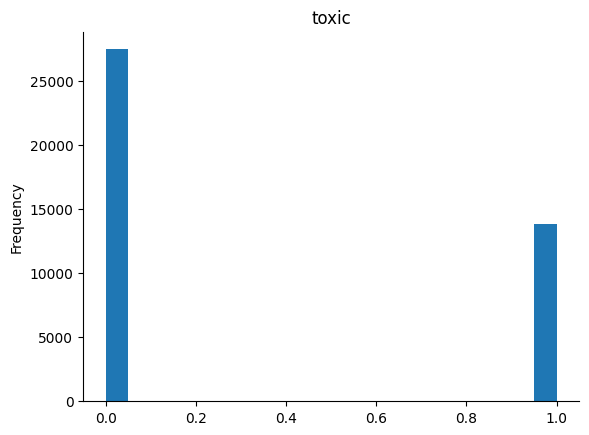

In [ ]:


from matplotlib import pyplot as plt
df_train['toxic'].plot(kind='hist', bins=20, title='toxic')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [23]:

#supprime les tokens vide
df_train["comment_text_tokenized_sw"] = df_train["comment_text_tokenized_sw"].apply(
    lambda tokens: [token for token in tokens if token.strip()]
)

df_validation["comment_text_tokenized_sw"] = df_validation["comment_text_tokenized_sw"].apply(
    lambda tokens: [token for token in tokens if token.strip()]
)

df_test["comment_text_tokenized_sw"] = df_test["comment_text_tokenized_sw"].apply(
    lambda tokens: [token for token in tokens if token.strip()]
)

In [ ]:


print(df_train['comment_text_tokenized_sw'].iloc[0])

['demonte', 'morton', 'u', 'bastard', 'stop', 'deletin', 'my', 'shit', 'u', 'white', 'trash', 'cracker', 'muthafucker', 'fuck', 'u', 'u', 'racist', 'bitch', 'i', 'hope', 'u', 'die']


In [24]:
#suppression des tokens contenant des liens
def remove_links(df, column_name):
    url_pattern = re.compile(r'http[s]?://|www\.')
    df[column_name] = df[column_name].apply(lambda tokens: [token for token in tokens if not re.match(url_pattern, token)])

    return df

df_train = remove_links(df_train, "comment_text_tokenized_sw")
df_test = remove_links(df_test, "comment_text_tokenized_sw")
df_validation = remove_links(df_validation, "comment_text_tokenized_sw")

In [25]:

def remplacer_mots_par_num(phrase):
    return ['num' if any(char.isdigit() for char in mot) else mot for mot in phrase]


#conversion en liste et remplacement de chaques tokens contenant des chiffre en "num"

df_train["comment_text_tokenized_sw"] = df_train["comment_text_tokenized_sw"].apply(remplacer_mots_par_num)


df_test["comment_text_tokenized_sw"] = df_test["comment_text_tokenized_sw"].apply(remplacer_mots_par_num)


df_validation["comment_text_tokenized_sw"] = df_validation["comment_text_tokenized_sw"].apply(remplacer_mots_par_num)



In [26]:
#nettoyage des tokens
def clean_tokens(df, column_name):

    # Fonction pour nettoyer un token
    def clean_token(token):
        # Supprimer les caractères non-alphanumériques au début et à la fin
        return re.sub(r'^[^a-zA-Z0-9]+|[^a-zA-Z0-9]+$', '', token)

    # Appliquer la fonction de nettoyage à chaque token de la colonne
    df[column_name] = df[column_name].apply(
        lambda tokens: [clean_token(token) for token in tokens if clean_token(token)]  # Nettoie et enlève les tokens vides
    )

    return df

df_train = clean_tokens(df_train, "comment_text_tokenized_sw")
df_test = clean_tokens(df_test, "comment_text_tokenized_sw")
df_validation = clean_tokens(df_validation, "comment_text_tokenized_sw")


In [27]:
#separation du dataset en deux colonnes, avec et sans stopword pour pouvoir tester l'entrainmenet avec les deux différent

nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])
def remove_stop_word(df, token_column):
    #Supprime les stop words d'une colonne contenant des listes de tokens.

    def remove_stopwords(tokens):
        return [token for token in tokens if not nlp.vocab[token].is_stop]

    # Appliquer la suppression des stop words sur la colonne spécifiée
    return df[token_column].apply(remove_stopwords)

# dans la colonne comment_text_tokenized, supprimer les stopword de la colonne comment_text_tokenized_sw
df_train['comment_text_tokenized'] = remove_stop_word(df_train, 'comment_text_tokenized_sw')
df_test['comment_text_tokenized'] = remove_stop_word(df_test, 'comment_text_tokenized_sw')
df_validation['comment_text_tokenized'] = remove_stop_word(df_validation, 'comment_text_tokenized_sw')

In [28]:
df_train.to_csv("/content/drive/MyDrive/train_preprocessed.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/test_preprocessed.csv", index=False)
df_validation.to_csv("/content/drive/MyDrive/validation_preprocessed.csv", index=False)

In [29]:
df_train = pd.read_csv("/content/drive/MyDrive/train_preprocessed.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_preprocessed.csv")
df_validation = pd.read_csv("/content/drive/MyDrive/validation_preprocessed.csv")

In [30]:
# Convert columns back to lists
df_train['comment_text_tokenized_sw'] = df_train['comment_text_tokenized_sw'].apply(ast.literal_eval)
df_train['comment_text_tokenized'] = df_train['comment_text_tokenized'].apply(ast.literal_eval)

df_test['comment_text_tokenized_sw'] = df_test['comment_text_tokenized_sw'].apply(ast.literal_eval)
df_test['comment_text_tokenized'] = df_test['comment_text_tokenized'].apply(ast.literal_eval)

df_validation['comment_text_tokenized_sw'] = df_validation['comment_text_tokenized_sw'].apply(ast.literal_eval)
df_validation['comment_text_tokenized'] = df_validation['comment_text_tokenized'].apply(ast.literal_eval)

In [31]:
#creation d'un dictionnaire avec la colomne contenant les sequences avec stopword pour associer un mot a une identifiant numérique

def get_dico(dataframe, column_name):

    # Vérification que la colonne contient des listes de mots
    if not all(isinstance(row, list) for row in dataframe[column_name]):
        raise ValueError("La colonne spécifiée doit contenir des listes de mots tokenisés.")

    # Extraire tous les mots tokenisés et créer un ensemble unique
    all_tokens = [word for tokens in dataframe[column_name] for word in tokens]
    unique_words = sorted(set(all_tokens))  # Tri des mots pour cohérence

    # Créer un DataFrame avec les mots et leurs indices
    dico_df = pd.DataFrame({'word': unique_words, 'id': range(len(unique_words))})
    return dico_df



df_dico = get_dico(df_train, "comment_text_tokenized_sw")

print(df_dico.head())

               word  id
0                 a   0
1  a""lexicographer   1
2           a""plan   2
3              a$$e   3
4           a$$hole   4


In [32]:
df_dico.shape

(67379, 2)

In [33]:
#utilisation du dico créé pour convertir la colomne avec les sequence sans stopword
def convert_with_dico(dataframe, column_name, dico_df):

    # Création d'un mapping mot -> ID à partir du DataFrame dictionnaire
    word_to_id = pd.Series(dico_df['id'].values, index=dico_df['word']).to_dict()

    dataframe = dataframe.copy()
    dataframe[column_name + "numbered"] = dataframe[column_name].apply(
        lambda tokens: [word_to_id.get(word, -1) for word in tokens]  # -1 pour les mots non trouvés
    )
    return dataframe


df_train = convert_with_dico(df_train, "comment_text_tokenized_sw", df_dico)
df_test = convert_with_dico(df_test, "comment_text_tokenized_sw", df_dico)
df_validation = convert_with_dico(df_validation, "comment_text_tokenized_sw", df_dico)


df_train = convert_with_dico(df_train, "comment_text_tokenized", df_dico)
df_test = convert_with_dico(df_test, "comment_text_tokenized", df_dico)
df_validation = convert_with_dico(df_validation, "comment_text_tokenized", df_dico)

In [34]:
df_dico


,word,id
0,a,0
1,"a""""lexicographer",1
2,"a""""plan",2
3,a$$e,3
4,a$$hole,4
...,...,...
67374,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,67374
67375,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,67375
67376,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,67376
67377,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,67377


In [35]:
df_validation.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_tokenized_sw,comment_text_tokenized,comment_text_tokenized_swnumbered,comment_text_tokenizednumbered
0,4b001055c2fd4f05,the blonde ignorant and pale skin,1,0,0,0,0,0,"[the, blonde, ignorant, and, pale, skin]","[blonde, ignorant, pale, skin]","[58883, 6889, 28116, 2333, 43205, 54123]","[6889, 28116, 43205, 54123]"
1,5e13a669a39ebcfc,"Ok, that works. Thanks!",0,0,0,0,0,0,"[ok, that, work, thank]","[ok, work, thank]","[41900, 58858, 65951, 58831]","[41900, 65951, 58831]"
2,189e7f6790e16950,"""4. This last summary is partly from chapters ...",0,0,0,0,0,0,"[num, this, last, summary, be, partly, from, c...","[num, summary, partly, chapter, haslett, b, b,...","[41275, 59172, 33415, 56999, 5531, 43577, 2243...","[41275, 56999, 43577, 9905, -1, 4632, 4632, -1..."
3,5dbf997ff526ba94,"Sorry, I was unclear. I support your breaking ...",0,0,0,0,0,0,"[sorry, i, be, unclear, i, support, your, brea...","[sorry, unclear, support, break, category, con...","[55042, 27793, 5531, 61570, 27793, 57172, 6685...","[55042, 61570, 57172, 7670, 9384, 12328, 59944..."
4,04ae4b01d87a9b9b,"Not only it's a theory, today most experts bel...",0,0,0,0,0,0,"[not, only, it, be, a, theory, today, most, ex...","[theory, today, expert, believe, aryans, come,...","[41005, 42105, 30193, 5531, 0, 59004, 59755, 3...","[59004, 59755, 19988, 5845, 3684, 11478, 17747..."


In [36]:
df_train.to_csv("/content/drive/MyDrive/train_preprocessed.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/test_preprocessed.csv", index=False)
df_validation.to_csv("/content/drive/MyDrive/validation_preprocessed.csv", index=False)
df_dico.to_csv("/content/drive/MyDrive/dico.csv", index=False)